# Unexpected Test Failures

In this notebook we initially set out to predict infrastructure flakes from testgrid data. Usually an infrastructure flake can be categorized by several tests failing unexpectedly at the same time, which would mean that the problem wasn't the tests themselves, but rather the infrastructure they run on. The main challenge came from defining mathematically what it could mean for tests to fail unexpectedly. That became the main goal of this notebook and classifying why the tests failed unexpectedly, whether it be because of infrastructure or other reasons, will require further analysis. In this notebook, every column of testgrid data will be classified with a "unexpectedness score" that is really a probability from 0 to 100.

## Load Data

In [117]:
import json
import gzip
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime
import numpy as np
from matplotlib import colors
import bisect
from ipynb.fs.defs.metric_template import CephCommunication
from ipynb.fs.defs.metric_template import save_to_disk
from dotenv import load_dotenv, find_dotenv
import sys

sys.path.append('../../../failure-type-classification')

sys.path.append('../../../failure-type-classification')

from ipynb.fs.defs.failure_type_functions import ( #noqa
    normalize, #noqa
    decode_run_length, #noqa
)

load_dotenv(find_dotenv())

True

In [10]:
## Specify variables
METRIC_NAME = "unexpected_runs"
# Specify the path for input grid data,
INPUT_DATA_PATH = "../../../../data/raw/testgrid_810.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_input_data_path = "raw_data"
metric_path = f"ai4ci/testgrid/metrics/{METRIC_NAME}"

In [14]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

In [15]:
all_dashboards = list(testgrid_data.keys())

all_jobs = {key: list(testgrid_data[key].keys()) for key in all_dashboards}

In [16]:
# for data exploration

def get_random_grid():
    """Call this function and get a totally random grid."""
    first = np.random.choice(all_dashboards)
    second = np.random.choice(all_jobs[first])
    grid = testgrid_data[first][second]['grid']
    x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))
    x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])
    return first, second, x

## Visualizing

Below we visualize some improbable failures. We define a metric (probability of failure) that is just the sample probability of failure, $\overline{X}$. If the probability of failure is < 0.05 and it fails, we mark it in yellow.

In [17]:
def naive_prob_failure(row):
    """Input a row and get the probability that test fails, given that it is run."""
    row = row.values
    row = row[row != 0]
    return 1 - (row.mean() + 1)/2

In [99]:
def get_grid(x):
    """Plot the grid with not run tests in white, improb
    able failed tests in yellow, other failed tests in red, and passed in green."""
    plt.figure(figsize=(10, 5))
    y = x[:50].copy()
    for i, row in y.iterrows():
        pf = naive_prob_failure(row)
        if pf <= 0.05:
            row[row == -1] = 0.5
            y.loc[i] = row
    cmap = colors.ListedColormap(['red', 'white', 'yellow', 'green'])
    boundaries = [-1.2, -0.2, 0.2, 0.7, 1.2]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    sns.heatmap(y[:50], fmt="", cmap=cmap, cbar=False, norm = norm)
    plt.ylabel("Tests")
    plt.xlabel("Run")
    plt.show()

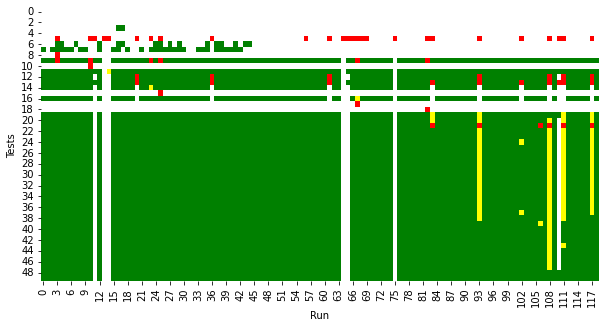

In [101]:
dashboard, job, x = get_random_grid()
get_grid(x)

## Unexpected Failure Classification

First we will walk through the process with visualizations to motivate our methods before defining an overall function to calculate an "unexpectedness score".

In [102]:
def preprocess(x):
    """Preprocess the data to make our methods work."""
    # unsure why we have NA values; safest bet to fix is to assume test didn't run
    x = x.fillna(0)
    print('Proportion of NA values', x.isna().to_numpy().sum()/(x.shape[0]*x.shape[1]))
    # if we have all the same values, there is no real info (for our methods)
    x = x[~(x.apply(np.std, axis = 1) == 0)]
    return x


x = preprocess(x)

Proportion of NA values 0.0


Now we define a column score. We earlier defined the row score as the sample probability of a test failing. Rows correspond to tests and columns refer to time. For the column score, we take all the tests that failed at that time, and take the sums of the <em> entropies </em> of the failed scores. Entropy is just the negative of the log of the row score. It just makes probabilities work in a more linear fashion. Usually if you accumulate multiple probabilities you would multiply them together but that would make a lot of numbers really small and hard to understand so we apply the log. There are reasons for this being called "entropy" that could be read [here](https://en.wikipedia.org/wiki/Information_theory). So if a run has 3 tests fail where two tests had a $\frac25$ probability of failing and a one test had a $\frac13$ probability of failing our column score will be $-2\log\frac25 - \log\frac13$.

In [103]:
def column_scores(x):
    # defined as the sum of the log of probability to fail of the failed tests
    row_scores = x.apply(naive_prob_failure, axis = 1).values
    return x.apply(lambda x: column_score(x, row_scores))


def column_score(column, row_scores):
    return np.sum(-np.log(row_scores[column == -1]))

Now let's visualize what our column scores look like next to the grid itself.

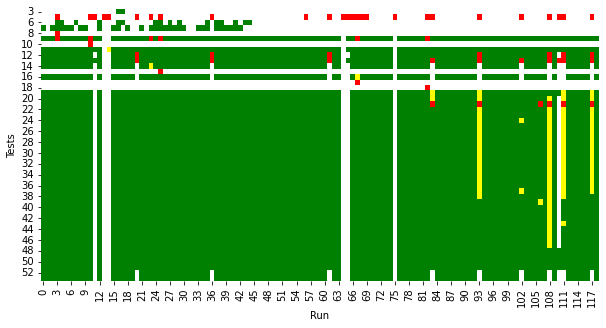

In [104]:
get_grid(x)

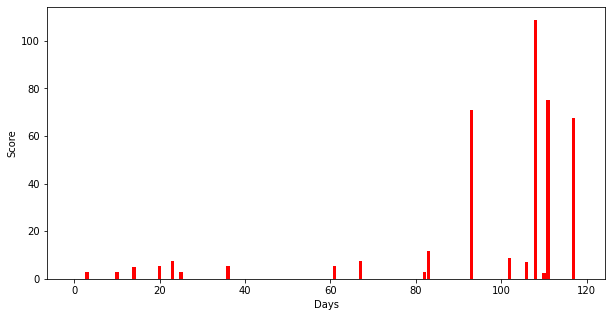

In [105]:
col_scores = column_scores(x)

plt.figure(figsize=(10, 5))
plt.bar(x = x.columns, height = col_scores, color = 'r')
plt.ylabel("Score")
plt.xlabel("Days")
plt.show()

Interestingly, the one flake we think we see at around day 13 has a score that is not as large as serveral of the other days. It is important to keep in mind that we are only seeing the first 50 tests that had a failure for visibility purposes, and there are hundreds more that extend theoretically very far below this graph.

Now that we have these scores, we need to decide what a high score would be. We do this by performing a monte carlo simulation to get an approximate idea of the distribution. With every test there is a porbability associated with it, and a score. To generate a random column we simply add $-\log p$ to the score with a probability of $p$. We do this for every test and return the resulting total score.

In [106]:
def random_trial(row_scores):
    row_scores = row_scores[row_scores != 0]
    scores_scores = -np.log(row_scores)
    tot = 0
    for a, b in zip(row_scores, scores_scores):
        tot  += b * np.random.binomial(1, p = a)
    return tot

In [107]:
# this is a large number of simulations and can be adjusted later
n_sims = 10000

row_scores = x.apply(naive_prob_failure, axis = 1).values
out = [random_trial(row_scores) for i in range(n_sims)]

<AxesSubplot:ylabel='Count'>

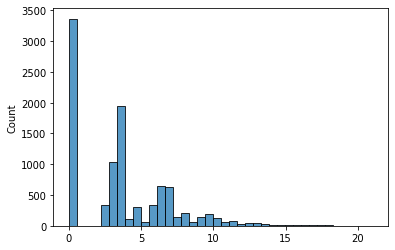

In [109]:
sns.histplot(out)

We can see our distribution is fairly smooth, which happens when we have enough tests that have any probability of failing. We will also output the true distribution of scores to compare.

<AxesSubplot:ylabel='Probability'>

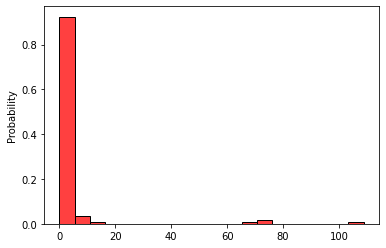

In [110]:
sns.histplot(column_scores(x), stat = 'probability', color = 'r', bins = 20)

We see these look nothing alike. Randomly running simulations does not accurately imitate what the testgrid data looks like, but rather exposes where the unexpectedness is too high to have been a result of a couple random failures.

We classify a couple levels of significance: 10%, 5%, and 1%. We see if the true scores are in the top x% of the simulated distribution.

In [111]:
out = sorted(out)

n = len(out)

idx1 = int(0.90*n)
idx2 = int(0.95*n)
idx3 = int(0.99*n)

print(f'0.05 significance: {out[idx1]}')
print(f'0.01 significance: {out[idx2]}')
print(f'0.001 significance: {out[idx3]}')

0.05 significance: 8.050703381470303
0.01 significance: 9.933434628904084
0.001 significance: 13.616500113152597


We visualize these cutoffs below.

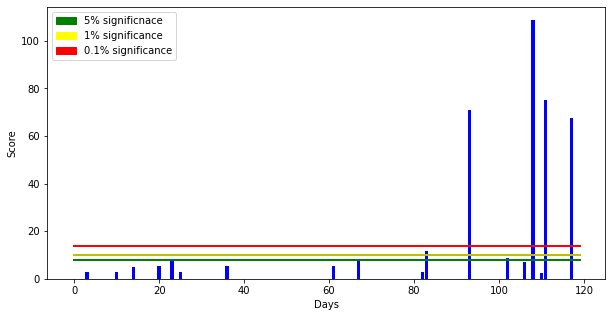

In [121]:
col_scores = column_scores(x)

plt.figure(figsize=(10, 5))
plt.bar(x = x.columns, height = col_scores, color = 'b')
plt.ylabel("Score")
plt.xlabel("Days")
x1 = 0
x2 = len(col_scores)

plt.plot([x1, x2], [out[idx1],out[idx1]], color='g', linestyle='-', linewidth=2)
plt.plot([x1, x2], [out[idx2],out[idx2]], color='y', linestyle='-', linewidth=2)
plt.plot([x1, x2], [out[idx3],out[idx3]], color='r', linestyle='-', linewidth=2)

green_patch = mpatches.Patch(color='green', label='5% significnace')
yellow_patch = mpatches.Patch(color='yellow', label='1% significance')
red_patch = mpatches.Patch(color='red', label='0.1% significance')

plt.legend(handles=[green_patch, yellow_patch, red_patch])
plt.show()

In this case the scores were so anomolous that the significance levels didn't end up making a big difference.

We define the final score as being the percentile of where our actual data lies on the simulated distribution. Thus, the highest, most anomolous score is 1 (being greater than any simulated score), and the lowest is 0. Below we define the main function that will assign a probability to every column of testgrid data.

In [40]:
def score_grid(grid):
    grid = preprocess(grid)
    # get col_scores
    col_scores = column_scores(grid)
    n_sims = 1000
    row_scores = grid.apply(naive_prob_failure, axis = 1).values
    out = sorted([random_trial(row_scores) for i in range(n_sims)])
    ret = []
    for col_score in col_scores:
        ret_val = bisect.bisect_left(out, col_score)
        ret.append(ret_val/1000)
    return ret

## Analysis of Scores

In [ ]:
all_grids = []
data = []
for i in all_dashboards:
    for j in all_jobs[i]:
        all_grids.append((i, j))
for n, (i,j) in enumerate(all_grids):
    if n % 100 == 0:
        print(n)
    x = testgrid_data[i][j]['grid']
    x = np.array(list(pd.DataFrame(x).statuses.apply(decode_run_length)))
    x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])
    for idx, val in enumerate(score_grid(x)):
        data.append([i, j, idx, val])

In [80]:
scores_df = pd.DataFrame(data, columns = ['dashboard', 'job', 'column', 'score'])

In [83]:
scores_df.sample(5)

,dashboard,job,column,score
38411,"""redhat-openshift-ocp-release-4.7-informing""",release-openshift-ocp-installer-e2e-gcp-serial...,61,1.000
41419,"""redhat-openshift-ocp-release-4.7-informing""",release-openshift-origin-installer-old-rhcos-e...,1,0.078
47293,"""redhat-osde2e-stage-moa""",osde2e-stage-moa-e2e-default,93,0.049
27374,"""redhat-openshift-ocp-release-4.5-informing""",release-openshift-origin-installer-old-rhcos-e...,116,0.000
5784,"""redhat-openshift-ocp-release-4.3-blocking""",release-openshift-ocp-installer-e2e-aws-serial...,2,0.000


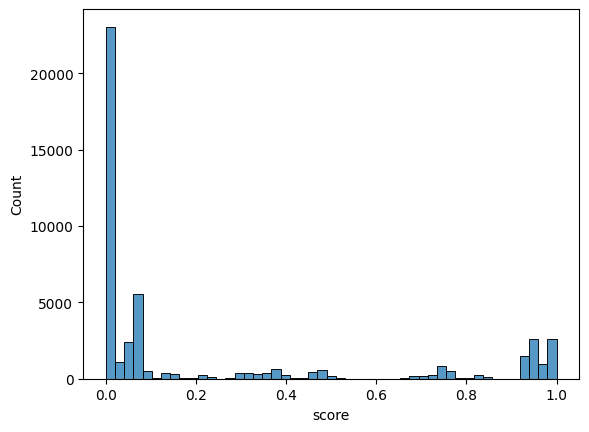

In [93]:
sns.histplot(scores_df['score'])
plt.show()

We see that the tests can mostly be put into two categories: near 0, and near 1.

In [97]:
n_cols = len(scores_df)

print(f"Less than 10%: {sum(scores_df['score'] < .1) / n_cols}")
print(f"More than 90%: {sum(scores_df['score'] > .9) / n_cols}")

Less than 10%: 0.686293476889431
More than 90%: 0.16101694915254236


Those two categories make up ~85% of the columns.

Are runs related to their previous run? We had an intuition that infra flakes show up as waterfall patterns, and the infrastructure continues to be flaky for more than one run. We would like to see if there is correlation between subsequent runs that shows up.

In [102]:
all_data = []
for i, j in all_grids:
    scores = scores_df[(scores_df['dashboard'] == i) & (scores_df['job'] == j)].score.values
    all_data += list(zip(scores[:-1], scores[1:]))

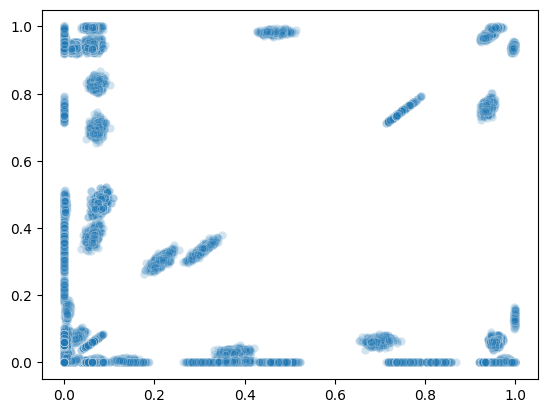

In [110]:
sns.scatterplot(x = [d[0] for d in all_data], y = [d[1] for d in all_data], alpha = 0.2)
plt.show()

While this is certainly an interesting looking plot. There isn't too much to take away from this in my opinion except that things seem pretty random.

We define an unexpected column as having a score >0.9. We wish to look at the histograms of scores coming directly after an unexpected run and an expected run (score <.10).

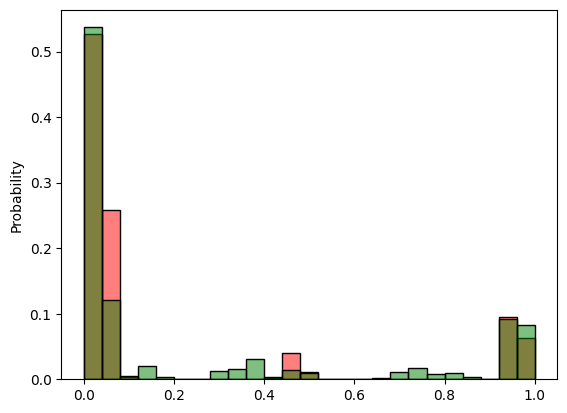

In [115]:
unexpected_scores = [d[0] for d in all_data if d[1] > 0.9 ]
expected_scores = [d[0] for d in all_data if d[1] < 0.1]

sns.histplot(unexpected_scores, stat = 'probability', color = 'r', bins = 25, alpha = 0.5)
sns.histplot(expected_scores, stat = 'probability', color = 'g', bins = 25, alpha = 0.5)
plt.show()

We really don't see much difference here either. It would be pretty safe to say a high column score don't affect the next column's score all that much.

## Save to Ceph or Local

In [100]:
filename = f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet"

if AUTOMATION == "True":
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(scores_df, metric_path, filename)
else:
    save_to_disk(scores_df, OUTPUT_DATA_PATH, filename)

## Conclusion

We came up with a method to classify the unexpectness of a given number of tests failing during a run. We are going to use this along with other data from the run to try to extract useful information about what makes these runs have such unexpected failures.